In [30]:
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_blobs, make_moons
from sklearn.linear_model import LogisticRegression

import numpy as np
import pickle
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def compare_measures(m1, m2, name1, name2, ax=None):
    m1 = m1.flatten()
    m2 = m2.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]
    print(f"Correlation between {name1} and {name2}: {correlation.item():.4f}")

    if ax is not None:
        ax.scatter(m1, m2, alpha=0.5, s=5)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        ax.set_title(f"Correlation: {correlation.item():.4f}")

        z = np.polyfit(m1.numpy(), m2.numpy(), 1)
        p = np.poly1d(z)
        x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

    return correlation.item()

In [32]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        return x

    def get_logits(self, x):
        return self.layer_1(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [33]:
class ComplexModel(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.layer_1 = nn.Linear(2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        x = self.sigmoid(self.layer_2(x))
        return x

    def get_logits(self, x):
        x = self.sigmoid(self.layer_1(x))
        return self.layer_2(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [34]:
# Diagonal Hessian approximation using Fisher Information Matrix
def compute_hessian_diagonal(model, data_x, data_y, prior_precision=0.01):
    n_params = model.count_parameters()
    hessian_diag = torch.zeros(n_params)

    for x, y in zip(data_x, data_y):
        x = x.unsqueeze(0)
        model.zero_grad()

        logits = model.get_logits(x)
        prob = torch.sigmoid(logits)

        loss = -torch.log(prob) if y > 0.5 else -torch.log(1 - prob)
        loss.backward()

        grads = []
        for param in model.parameters():
            if param.grad is not None:
                grads.append(param.grad.view(-1))
        grads = torch.cat(grads)

        hessian_diag += grads * grads

    hessian_diag += prior_precision

    return hessian_diag

In [35]:
def laplace_predict(model, x_test, posterior_variance, samples=100):
    n_test = len(x_test)

    all_preds = torch.zeros(samples, n_test)

    map_weights = model.parameters_as_vector()

    for i in range(samples):
        sampled_weights = map_weights + torch.randn_like(map_weights) * torch.sqrt(
            posterior_variance
        )

        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = sampled_weights[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        with torch.no_grad():
            all_preds[i] = model(x_test).squeeze()

    idx = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = map_weights[idx : idx + param_size].reshape(param.shape)
        idx += param_size

    pred_mean = all_preds.mean(0)
    pred_var = all_preds.var(0)

    return pred_mean, pred_var

In [36]:
def get_grad_norm(model, loss_fn, x, y):
    model.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [37]:
def get_grad_norm_grid(model, loss_fn, samples, permute=lambda x: x):
    viz_grad = []

    for x in samples:
        viz_grad.append(
            get_grad_norm(
                model,
                loss_fn,
                x.reshape(1, -1),
                permute(model(x.reshape(1, -1)).round()),
            )
        )

    return torch.tensor(viz_grad)

In [38]:
def calculate_gradient_stats(grad_uncertainty, grad_uncertainty_flipped):
    grad_avg = (grad_uncertainty + grad_uncertainty_flipped) / 2.0

    # Using the simplified formula for std of two values: std = |x1 - x2| / (sqrt(2))
    grad_std = torch.abs(grad_uncertainty - grad_uncertainty_flipped) / (
        torch.sqrt(torch.tensor(2.0))
    )

    return grad_avg, grad_std

In [39]:
def model_to_pyro(model, X, y, prior_precision=0.01):
    def model_fn():
        n_params = model.count_parameters()

        # Set up priors on all parameters
        # Using a single multivariate normal for all parameters
        scale = 1.0 / np.sqrt(prior_precision)
        prior = dist.Normal(
            loc=torch.zeros(n_params), scale=scale * torch.ones(n_params)
        ).to_event(1)

        # Sample parameters from prior
        params = pyro.sample("params", prior)

        # Apply parameters to the model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Forward pass through the model
        with torch.no_grad():
            logits = model.get_logits(X)

        # Likelihood
        with pyro.plate("data", len(X)):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

        return obs

    return model_fn

In [40]:
def run_mcmc_with_pyro(
    model, X, y, prior_precision=0.01, num_samples=1000, warmup_steps=200
):
    pyro_model = model_to_pyro(model, X, y, prior_precision)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    print("Pre-training model for MCMC initialization...")
    for epoch in range(100):
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    kernel = NUTS(pyro_model)

    print(f"Running NUTS MCMC sampler...")
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run()

    samples = mcmc.get_samples()

    return samples

In [41]:
def pyro_samples_to_matrix(samples):
    param_samples = samples["params"]
    return param_samples

In [42]:
def mcmc_predict_with_samples(model, X_test, param_samples):
    n_samples = param_samples.shape[0]
    n_test = X_test.shape[0]

    # Store predictions from all samples
    all_preds = torch.zeros(n_samples, n_test)

    # Make predictions for each sample
    for i in range(n_samples):
        # Extract parameters for this sample
        params = param_samples[i]

        # Apply parameters to model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Make predictions
        with torch.no_grad():
            preds = model(X_test)
            all_preds[i] = preds.squeeze()

    # Compute mean and variance
    pred_mean = all_preds.mean(dim=0)
    pred_var = all_preds.var(dim=0)

    return pred_mean, pred_var

In [43]:
class ExperimentSaver:
    def __init__(self, base_dir="saved_experiments/binary"):
        self.base_dir = base_dir
        os.makedirs(base_dir, exist_ok=True)

    def save_experiment(self, experiment_data, experiment_name=None):
        """Save experiment data with a unique time-stamped identifier."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        if experiment_name is None:
            experiment_id = f"exp_{timestamp}"
        else:
            experiment_id = f"{experiment_name}_{timestamp}"

        # Create experiment directory
        exp_dir = os.path.join(self.base_dir, experiment_id)
        os.makedirs(exp_dir, exist_ok=True)

        # Save experiment data
        filepath = os.path.join(exp_dir, "experiment.pkl")
        with open(filepath, "wb") as f:
            pickle.dump(experiment_data, f)

        print(f"Experiment saved as: {experiment_id}")
        print(f"Directory: {exp_dir}")
        return experiment_id, exp_dir

    def load_experiment(self, experiment_id):
        """Load experiment data by identifier."""
        exp_dir = os.path.join(self.base_dir, experiment_id)
        filepath = os.path.join(exp_dir, "experiment.pkl")

        if not os.path.exists(filepath):
            raise FileNotFoundError(
                f"Experiment {experiment_id} not found at {filepath}"
            )

        with open(filepath, "rb") as f:
            experiment_data = pickle.load(f)

        return experiment_data, exp_dir

    def list_experiments(self):
        """List all saved experiments."""
        experiments = []
        for dirname in os.listdir(self.base_dir):
            exp_path = os.path.join(self.base_dir, dirname)
            if os.path.isdir(exp_path):
                # Check if experiment.pkl exists in the directory
                pkl_path = os.path.join(exp_path, "experiment.pkl")
                if os.path.exists(pkl_path):
                    experiments.append(dirname)
        return sorted(experiments)

    def get_experiment_directory(self, experiment_id):
        """Get the directory path for a specific experiment."""
        return os.path.join(self.base_dir, experiment_id)

In [44]:
def train_standard_model(
    X,
    y,
    model_class,
    model_args=None,
    train_method="adam",
    prior_precision=0.01,
    epochs=1000,
    verbose=True,
):
    """Train a binary classification model using standard optimization."""
    if model_args is None:
        model_args = {}

    # Convert to PyTorch tensors
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)

    # Create and train the model
    model = model_class(**model_args)
    criterion = nn.BCELoss()

    if train_method == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            outputs = model(X)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose and (epoch + 1) % (epochs // 10) == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    elif train_method == "sklearn":
        X_np = X.numpy()
        y_np = y.numpy().ravel()  # flatten the targets

        logistic_model = LogisticRegression(fit_intercept=True, solver="lbfgs")
        logistic_model.fit(X_np, y_np)

        weights = logistic_model.coef_
        bias = logistic_model.intercept_

        with torch.no_grad():
            model.layer_1.weight.copy_(torch.tensor(weights))
            model.layer_1.bias.copy_(torch.tensor(bias))

    # Compute Laplace approximation
    hessian_diag = compute_hessian_diagonal(model, X, y, prior_precision)
    posterior_precision = hessian_diag
    posterior_variance = 1.0 / (posterior_precision + 1e-6)

    # Evaluate accuracy
    with torch.no_grad():
        pred_mean = model(X)
        correct = ((pred_mean > 0.5) == y.squeeze()).float().mean()

    if verbose:
        print(f"Accuracy on entire dataset: {correct.item():.4f}")

    # Create experiment data
    experiment_data = {
        "type": "standard",
        "model_state_dict": model.state_dict(),
        "model_class": model_class,
        "model_args": model_args,
        "X": X,
        "y": y,
        "accuracy": correct.item(),
        "criterion": criterion,
        "posterior_variance": posterior_variance,
        "prior_precision": prior_precision,
        "train_method": train_method,
        "mcmc_samples": None,
    }

    return experiment_data

In [45]:
def train_mcmc_model(
    X,
    y,
    model_class,
    model_args=None,
    prior_precision=0.01,
    num_samples=1000,
    warmup_steps=200,
    verbose=True,
):
    """Train a binary classification model using MCMC."""
    if model_args is None:
        model_args = {}

    # Convert to PyTorch tensors
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)

    # Create model and run MCMC
    model = model_class(**model_args)
    criterion = nn.BCELoss()

    samples = run_mcmc_with_pyro(
        model,
        X,
        y,
        prior_precision=prior_precision,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
    )

    param_samples = pyro_samples_to_matrix(samples)

    # Calculate accuracy using mean of posterior samples
    with torch.no_grad():
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = param_samples.mean(dim=0)[idx : idx + param_size].reshape(
                param.shape
            )
            idx += param_size

        pred_mean = model(X)
        correct = ((pred_mean > 0.5) == y.squeeze()).float().mean()

    if verbose:
        print(f"Accuracy on entire dataset: {correct.item():.4f}")

    # Create experiment data
    experiment_data = {
        "type": "mcmc",
        "model_state_dict": model.state_dict(),
        "model_class": model_class,
        "model_args": model_args,
        "X": X,
        "y": y,
        "accuracy": correct.item(),
        "criterion": criterion,
        "mcmc_samples": param_samples,
        "prior_precision": prior_precision,
        "posterior_variance": None,  # Not computed for MCMC
    }

    return experiment_data

In [46]:
def compute_uncertainty_measures(experiment_data):
    """Compute all uncertainty measures for a given experiment."""
    # Reconstruct model
    model = experiment_data["model_class"](**experiment_data["model_args"])
    model.load_state_dict(experiment_data["model_state_dict"])

    X = experiment_data["X"]
    y = experiment_data["y"]
    criterion = experiment_data["criterion"]
    mcmc_samples = experiment_data["mcmc_samples"]
    posterior_variance = experiment_data["posterior_variance"]

    # Create grid for uncertainty computation
    x_min, x_max = X[:, 0].min() - 5.5, X[:, 0].max() + 5.5
    y_min, y_max = X[:, 1].min() - 5.5, X[:, 1].max() + 5.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    # Get predictions on the grid
    with torch.no_grad():
        grid_probs = model(grid)
        grid_mean = grid_probs.reshape(xx.shape)

    # Standard Laplace uncertainty if available
    laplace_std = None
    if posterior_variance is not None:
        laplace_mean, laplace_var = laplace_predict(model, grid, posterior_variance)
        laplace_std = torch.sqrt(laplace_var).reshape(xx.shape)

    # MCMC uncertainty if available
    mcmc_std = None
    if mcmc_samples is not None:
        mcmc_mean, mcmc_var = mcmc_predict_with_samples(model, grid, mcmc_samples)
        mcmc_std = torch.sqrt(mcmc_var).reshape(xx.shape)

    # Compute gradient uncertainties
    gradient_uncertainty = get_grad_norm_grid(model, criterion, grid).reshape(xx.shape)
    gradient_uncertainty_flipped = get_grad_norm_grid(
        model, criterion, grid, lambda x: 1 - x
    ).reshape(xx.shape)

    # Calculate combined gradient measures
    grad_avg = (gradient_uncertainty + gradient_uncertainty_flipped) / 2.0
    grad_std = torch.abs(gradient_uncertainty - gradient_uncertainty_flipped) / (
        torch.sqrt(torch.tensor(2.0))
    )

    return {
        "xx": xx,
        "yy": yy,
        "grid_mean": grid_mean,
        "laplace_std": laplace_std,
        "mcmc_std": mcmc_std,
        "gradient_uncertainty": gradient_uncertainty,
        "gradient_uncertainty_flipped": gradient_uncertainty_flipped,
        "grad_avg": grad_avg,
        "grad_std": grad_std,
    }

In [47]:
def save_individual_plot(
    xx,
    yy,
    data,
    X,
    y,
    title,
    filename,
    exp_dir,
    plot_type="contour",
    cmap="viridis",
    levels=None,
):
    """Save an individual subplot as a separate image file in the experiment directory."""
    plt.figure(figsize=(8, 6))

    if plot_type == "contour":
        if levels is not None:
            plt.contourf(xx, yy, data, alpha=0.8, cmap=cmap, levels=levels)
        else:
            plt.contourf(xx, yy, data, alpha=0.8, cmap=cmap)
        plt.colorbar()

    plt.scatter(
        X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdBu_r, edgecolors="k", s=20
    )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()

    filepath = os.path.join(exp_dir, f"{filename}.png")
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()  # Close to free memory

    return filepath

In [48]:
def save_individual_correlation_plot(data1, data2, name1, name2, filename, exp_dir):
    """Save an individual correlation plot."""
    plt.figure(figsize=(8, 6))

    m1 = data1.flatten()
    m2 = data2.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]

    plt.scatter(m1, m2, alpha=0.5, s=5)
    plt.xlabel(name1)
    plt.ylabel(name2)

    # Add correlation line
    z = np.polyfit(m1.numpy(), m2.numpy(), 1)
    p = np.poly1d(z)
    x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
    plt.plot(x_range, p(x_range), "r--", alpha=0.8)

    plt.tight_layout()

    filepath = os.path.join(exp_dir, f"{filename}.png")
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()

    return filepath, correlation.item()

In [49]:
def save_correlation_plots(
    base_uncertainty, gradient_measures, exp_dir, base_name="Base"
):
    """Save individual correlation plots between base uncertainty and gradient measures."""
    correlations = {}
    saved_files = []

    measure_names = {
        "gradient_uncertainty": "Gradient (Same)",
        "gradient_uncertainty_flipped": "Gradient (Flipped)",
        "grad_avg": "Gradient (Avg)",
        "grad_std": "Gradient (Std)",
    }

    for key, grad_data in gradient_measures.items():
        if key in measure_names:
            filename = f"correlation_{base_name.lower()}_{key}"
            filepath, corr = save_individual_correlation_plot(
                base_uncertainty,
                grad_data,
                f"{base_name} Uncertainty",
                measure_names[key],
                filename,
                exp_dir,
            )
            correlations[f"corr_{base_name.lower()}_{key}"] = corr
            saved_files.append(filepath)

    return saved_files, correlations

In [50]:
def save_experiment_summary(experiment_data, correlations, exp_dir, experiment_id):
    """Save a text summary of the experiment results."""
    summary_path = os.path.join(exp_dir, "experiment_summary.txt")

    with open(summary_path, "w") as f:
        f.write(f"Experiment Summary: {experiment_id}\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Experiment Type: {experiment_data['type']}\n")
        f.write(f"Model Class: {experiment_data['model_class'].__name__}\n")
        f.write(f"Model Args: {experiment_data['model_args']}\n")
        f.write(f"Dataset Shape: {experiment_data['X'].shape}\n")
        f.write(f"Accuracy: {experiment_data['accuracy']:.4f}\n")
        f.write(f"Prior Precision: {experiment_data.get('prior_precision', 'N/A')}\n")

        if experiment_data["type"] == "standard":
            f.write(f"Training Method: {experiment_data.get('train_method', 'adam')}\n")
        elif experiment_data["type"] == "mcmc":
            f.write(
                f"MCMC Samples Shape: {experiment_data['mcmc_samples'].shape if experiment_data['mcmc_samples'] is not None else 'N/A'}\n"
            )

        f.write("\nCorrelations:\n")
        for key, value in correlations.items():
            if key.startswith("corr_"):
                f.write(f"{key}: {value:.4f}\n")

        f.write(f"\nGenerated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    return summary_path

In [51]:
def visualize_experiment(
    experiment_data,
    experiment_id,
    exp_dir,
    title_prefix="",
    save_plots=True,
    show_plots=True,
):
    """Visualize a saved experiment with option to save individual plots."""
    # Compute uncertainty measures
    uncertainty_data = compute_uncertainty_measures(experiment_data)

    X = experiment_data["X"]
    y = experiment_data["y"]
    exp_type = experiment_data["type"]

    xx = uncertainty_data["xx"]
    yy = uncertainty_data["yy"]
    grid_mean = uncertainty_data["grid_mean"]
    laplace_std = uncertainty_data["laplace_std"]
    mcmc_std = uncertainty_data["mcmc_std"]
    gradient_uncertainty = uncertainty_data["gradient_uncertainty"]
    gradient_uncertainty_flipped = uncertainty_data["gradient_uncertainty_flipped"]
    grad_avg = uncertainty_data["grad_avg"]
    grad_std = uncertainty_data["grad_std"]

    saved_files = []

    if save_plots:
        print(f"Saving plots to: {exp_dir}")

    # Define plot configurations
    plot_configs = [
        {
            "data": grid_mean.numpy(),
            "title": f"{title_prefix}\nDecision Boundary",
            "filename": "decision_boundary",
            "cmap": plt.cm.RdBu,
            "levels": np.linspace(0, 1, 11),
        }
    ]

    # Add uncertainty plots based on experiment type
    if exp_type == "standard" and laplace_std is not None:
        plot_configs.append(
            {
                "data": laplace_std.numpy(),
                "title": f"{title_prefix}\nLaplace Uncertainty",
                "filename": "laplace_uncertainty",
                "cmap": "viridis",
            }
        )

    if exp_type == "mcmc" and mcmc_std is not None:
        plot_configs.append(
            {
                "data": mcmc_std.numpy(),
                "title": f"{title_prefix}\nMCMC Uncertainty",
                "filename": "mcmc_uncertainty",
                "cmap": "viridis",
            }
        )

    # Add gradient uncertainty plots
    gradient_configs = [
        {
            "data": gradient_uncertainty.numpy(),
            "title": f"{title_prefix}\nGradient Uncertainty",
            "filename": "gradient_uncertainty",
            "cmap": "viridis",
        },
        {
            "data": gradient_uncertainty_flipped.numpy(),
            "title": f"{title_prefix}\nGradient Uncertainty (Flipped)",
            "filename": "gradient_uncertainty_flipped",
            "cmap": "viridis",
        },
        {
            "data": grad_avg.numpy(),
            "title": f"{title_prefix}\nAverage Gradient Uncertainty",
            "filename": "gradient_uncertainty_avg",
            "cmap": "viridis",
        },
        {
            "data": grad_std.numpy(),
            "title": f"{title_prefix}\nStd Between Gradient Uncertainties",
            "filename": "gradient_uncertainty_std",
            "cmap": "viridis",
        },
    ]

    plot_configs.extend(gradient_configs)

    # Save individual plots
    if save_plots:
        for config in plot_configs:
            filepath = save_individual_plot(
                xx,
                yy,
                config["data"],
                X,
                y,
                config["title"],
                config["filename"],
                exp_dir,
                "contour",
                config["cmap"],
                config.get("levels"),
            )
            saved_files.append(filepath)
            print(f"Saved: {os.path.basename(filepath)}")

    # Display combined plot if requested
    if show_plots:
        n_plots = len(plot_configs)
        plt.figure(figsize=(6 * n_plots, 5))

        for i, config in enumerate(plot_configs):
            plt.subplot(1, n_plots, i + 1)

            if config.get("levels") is not None:
                plt.contourf(
                    xx,
                    yy,
                    config["data"],
                    alpha=0.8,
                    cmap=config["cmap"],
                    levels=config["levels"],
                )
            else:
                plt.contourf(xx, yy, config["data"], alpha=0.8, cmap=config["cmap"])

            plt.colorbar()
            plt.scatter(
                X[:, 0],
                X[:, 1],
                c=y.squeeze(),
                cmap=plt.cm.RdBu_r,
                edgecolors="k",
                s=20,
            )
            plt.title(config["title"])
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")

        plt.tight_layout()
        plt.show()

    # Handle correlation plots
    correlations = {}

    # Determine which base uncertainty to use
    base_uncertainty = None
    base_name = None

    if exp_type == "standard" and laplace_std is not None:
        base_uncertainty = laplace_std
        base_name = "Laplace"
    elif exp_type == "mcmc" and mcmc_std is not None:
        base_uncertainty = mcmc_std
        base_name = "MCMC"

    if base_uncertainty is not None:
        gradient_measures = {
            "gradient_uncertainty": gradient_uncertainty,
            "gradient_uncertainty_flipped": gradient_uncertainty_flipped,
            "grad_avg": grad_avg,
            "grad_std": grad_std,
        }

        if save_plots:
            corr_files, correlations = save_correlation_plots(
                base_uncertainty, gradient_measures, exp_dir, base_name
            )
            saved_files.extend(corr_files)
            for corr_file in corr_files:
                print(f"Saved: {os.path.basename(corr_file)}")

        if show_plots:
            plt.figure(figsize=(20, 5))

            ax1 = plt.subplot(1, 4, 1)
            correlations[f"corr_{base_name.lower()}_gradient_uncertainty"] = (
                compare_measures(
                    base_uncertainty,
                    gradient_uncertainty,
                    f"{base_name} Uncertainty",
                    "Gradient (Same)",
                    ax1,
                )
            )

            ax2 = plt.subplot(1, 4, 2)
            correlations[f"corr_{base_name.lower()}_gradient_uncertainty_flipped"] = (
                compare_measures(
                    base_uncertainty,
                    gradient_uncertainty_flipped,
                    f"{base_name} Uncertainty",
                    "Gradient (Flipped)",
                    ax2,
                )
            )

            ax3 = plt.subplot(1, 4, 3)
            correlations[f"corr_{base_name.lower()}_grad_avg"] = compare_measures(
                base_uncertainty,
                grad_avg,
                f"{base_name} Uncertainty",
                "Gradient (Avg)",
                ax3,
            )

            ax4 = plt.subplot(1, 4, 4)
            correlations[f"corr_{base_name.lower()}_grad_std"] = compare_measures(
                base_uncertainty,
                grad_std,
                f"{base_name} Uncertainty",
                "Gradient (Std)",
                ax4,
            )

            plt.tight_layout()
            plt.show()

    # Print summary statistics
    print(f"Experiment ID: {experiment_id}")
    print(f"Experiment Type: {experiment_data['type']}")
    print(f"Accuracy: {experiment_data['accuracy']:.4f}")
    print(
        f"Average gradient uncertainty (same label): {gradient_uncertainty.mean().item():.4f}"
    )
    print(
        f"Average gradient uncertainty (flipped label): {gradient_uncertainty_flipped.mean().item():.4f}"
    )
    print(f"Average of gradient uncertainties: {grad_avg.mean().item():.4f}")
    print(f"Average std between gradient uncertainties: {grad_std.mean().item():.4f}")

    if base_uncertainty is not None:
        print(f"Average {base_name} uncertainty: {base_uncertainty.mean().item():.4f}")
        for key, value in correlations.items():
            if key.startswith("corr_"):
                print(f"{key}: {value:.4f}")

    if save_plots:
        print(f"Total plots saved: {len(saved_files)}")
        # Save experiment summary
        summary_path = save_experiment_summary(
            experiment_data, correlations, exp_dir, experiment_id
        )
        print(f"Summary saved: {os.path.basename(summary_path)}")

    return correlations, saved_files

In [52]:
def visualize_saved_experiments(experiment_ids=None, save_plots=True, show_plots=True):
    """Visualize saved experiments with options to save individual plots."""
    saver = ExperimentSaver()

    if experiment_ids is None:
        experiment_ids = saver.list_experiments()
        print(f"Available experiments: {experiment_ids}")

    results = {}
    all_saved_files = []

    for exp_id in experiment_ids:
        print(f"\n" + "=" * 60)
        print(f"Visualizing experiment: {exp_id}")

        try:
            exp_data, exp_dir = saver.load_experiment(exp_id)
            title = exp_id.replace("_", " ").title()
            correlations, saved_files = visualize_experiment(
                exp_data,
                exp_id,
                exp_dir,
                title_prefix=title,
                save_plots=save_plots,
                show_plots=show_plots,
            )
            results[exp_id] = {
                "accuracy": exp_data["accuracy"],
                "type": exp_data["type"],
                **correlations,
            }
            all_saved_files.extend(saved_files)
        except Exception as e:
            print(f"Error visualizing {exp_id}: {e}")

    # Print summary
    print("\n" + "=" * 60)
    print("EXPERIMENT SUMMARY")
    print("=" * 60)

    for exp_id, data in results.items():
        print(f"\n{exp_id}:")
        print(f"  Type: {data['type']}")
        print(f"  Accuracy: {data['accuracy']:.4f}")

        # Print correlations based on experiment type
        corr_keys = [k for k in data.keys() if k.startswith("corr_")]
        for key in sorted(corr_keys):
            print(f"  {key}: {data[key]:.4f}")

    if save_plots:
        print(f"\nTotal plots saved across all experiments: {len(all_saved_files)}")

    return results, all_saved_files

In [53]:
def get_experiments_by_pattern(pattern):
    """Get experiment IDs that match a pattern (e.g., 'mcmc', 'simple', 'blobs')."""
    saver = ExperimentSaver()
    all_experiments = saver.list_experiments()

    matching = [
        exp_id for exp_id in all_experiments if pattern.lower() in exp_id.lower()
    ]

    print(f"Experiments matching '{pattern}':")
    for exp_id in matching:
        print(f"  - {exp_id}")

    return matching

In [56]:
X_blobs, y_blobs = make_blobs(
    n_samples=1000, centers=[[-2, -2], [2, 2]], n_features=2, random_state=42
)

X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)

In [57]:
saver = ExperimentSaver()

In [78]:
# Experiment 1: Simple model on blobs (standard training)
exp1_data = train_standard_model(
    X_blobs, y_blobs, SimpleModel, epochs=100, train_method="adam"
)
exp1_id, _ = saver.save_experiment(exp1_data, "simple_blobs_standard")

Epoch [10/100], Loss: 0.5606
Epoch [20/100], Loss: 0.4228
Epoch [30/100], Loss: 0.3259
Epoch [40/100], Loss: 0.2595
Epoch [50/100], Loss: 0.2136
Epoch [60/100], Loss: 0.1810
Epoch [70/100], Loss: 0.1570
Epoch [80/100], Loss: 0.1387
Epoch [90/100], Loss: 0.1242
Epoch [100/100], Loss: 0.1126
Accuracy on entire dataset: 0.5000
Experiment saved as: simple_blobs_standard_20250608_223033
Directory: saved_experiments/binary/simple_blobs_standard_20250608_223033



Visualizing experiment: simple_blobs_standard_20250608_223033


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74606/1655715741.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Saving plots to: saved_experiments/binary/simple_blobs_standard_20250608_223033
Saved: decision_boundary.png
Saved: laplace_uncertainty.png
Saved: gradient_uncertainty.png
Saved: gradient_uncertainty_flipped.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


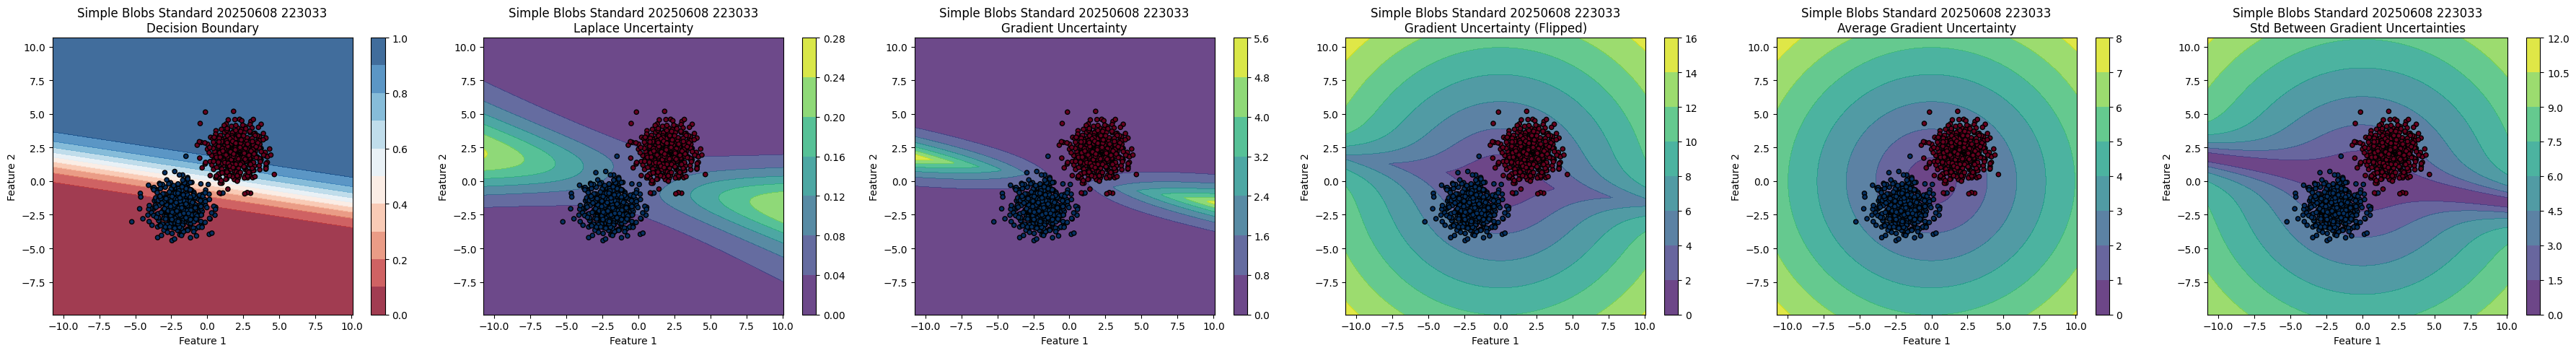

Saved: correlation_laplace_gradient_uncertainty.png
Saved: correlation_laplace_gradient_uncertainty_flipped.png
Saved: correlation_laplace_grad_avg.png
Saved: correlation_laplace_grad_std.png
Correlation between Laplace Uncertainty and Gradient (Same): 0.8871
Correlation between Laplace Uncertainty and Gradient (Flipped): -0.4039
Correlation between Laplace Uncertainty and Gradient (Avg): -0.2120
Correlation between Laplace Uncertainty and Gradient (Std): -0.5504


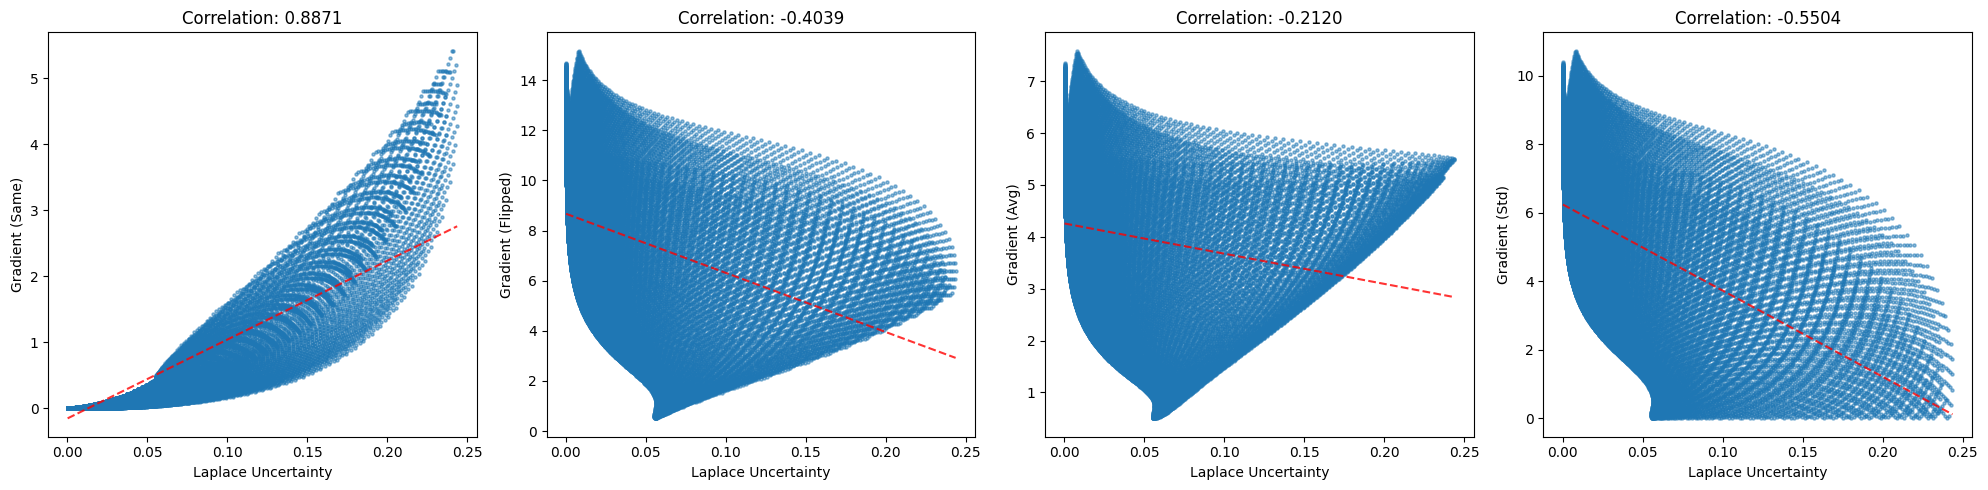

Experiment ID: simple_blobs_standard_20250608_223033
Experiment Type: standard
Accuracy: 0.5000
Average gradient uncertainty (same label): 0.3237
Average gradient uncertainty (flipped label): 7.7253
Average of gradient uncertainties: 4.0245
Average std between gradient uncertainties: 5.2337
Average Laplace uncertainty: 0.0401
corr_laplace_gradient_uncertainty: 0.8871
corr_laplace_gradient_uncertainty_flipped: -0.4039
corr_laplace_grad_avg: -0.2120
corr_laplace_grad_std: -0.5504
Total plots saved: 10
Summary saved: experiment_summary.txt

EXPERIMENT SUMMARY

simple_blobs_standard_20250608_223033:
  Type: standard
  Accuracy: 0.5000
  corr_laplace_grad_avg: -0.2120
  corr_laplace_grad_std: -0.5504
  corr_laplace_gradient_uncertainty: 0.8871
  corr_laplace_gradient_uncertainty_flipped: -0.4039

Total plots saved across all experiments: 10


In [79]:
results, saved_files = visualize_saved_experiments([exp1_id], save_plots=True, show_plots=True)

In [82]:
# Experiment 2: Complex model on moons (standard training)
exp2_data = train_standard_model(
    X_moons, y_moons, ComplexModel, {"hidden_size": 32},
    epochs=1000, prior_precision=0.001
)
exp2_id, _ = saver.save_experiment(exp2_data, "complex_moons_standard")

Epoch [100/1000], Loss: 0.2594
Epoch [200/1000], Loss: 0.2360
Epoch [300/1000], Loss: 0.1794
Epoch [400/1000], Loss: 0.1352
Epoch [500/1000], Loss: 0.0938
Epoch [600/1000], Loss: 0.0552
Epoch [700/1000], Loss: 0.0341
Epoch [800/1000], Loss: 0.0223
Epoch [900/1000], Loss: 0.0149
Epoch [1000/1000], Loss: 0.0107
Accuracy on entire dataset: 0.5000
Experiment saved as: complex_moons_standard_20250608_223128
Directory: saved_experiments/binary/complex_moons_standard_20250608_223128



Visualizing experiment: complex_moons_standard_20250608_223128


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74606/1655715741.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Saving plots to: saved_experiments/binary/complex_moons_standard_20250608_223128
Saved: decision_boundary.png
Saved: laplace_uncertainty.png
Saved: gradient_uncertainty.png
Saved: gradient_uncertainty_flipped.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


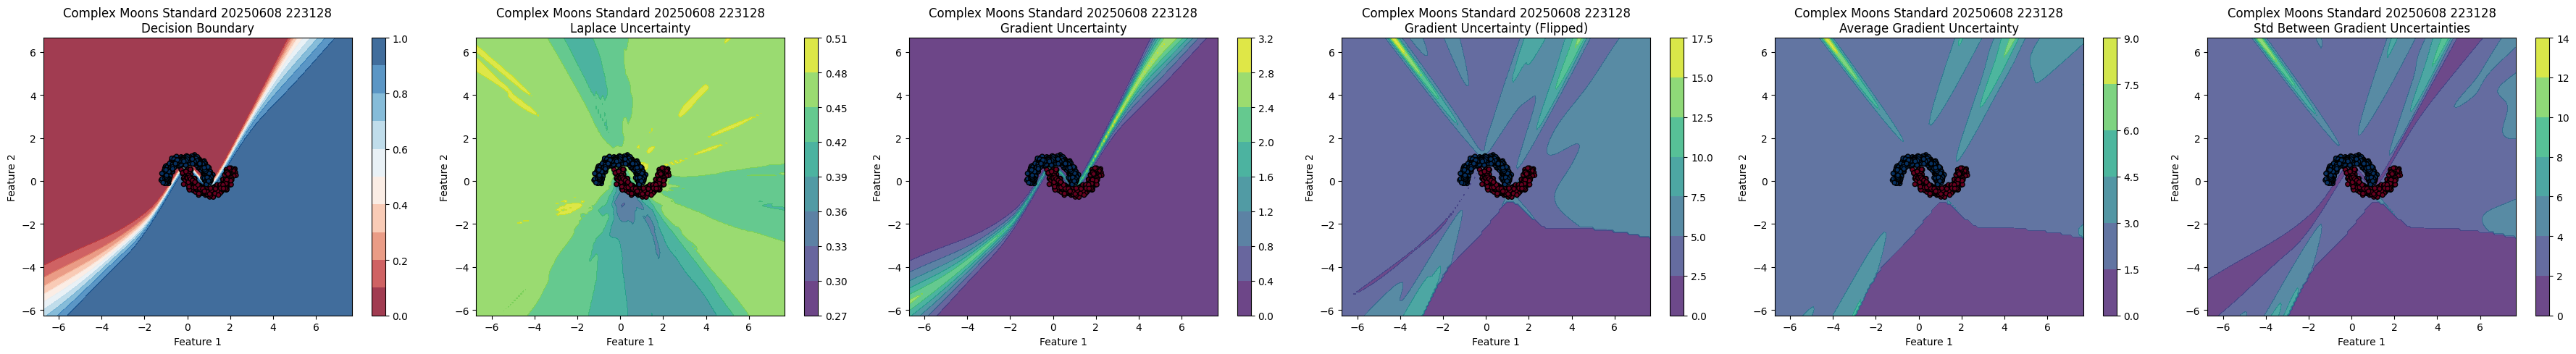

Saved: correlation_laplace_gradient_uncertainty.png
Saved: correlation_laplace_gradient_uncertainty_flipped.png
Saved: correlation_laplace_grad_avg.png
Saved: correlation_laplace_grad_std.png
Correlation between Laplace Uncertainty and Gradient (Same): 0.1985
Correlation between Laplace Uncertainty and Gradient (Flipped): 0.4723
Correlation between Laplace Uncertainty and Gradient (Avg): 0.5020
Correlation between Laplace Uncertainty and Gradient (Std): 0.4246


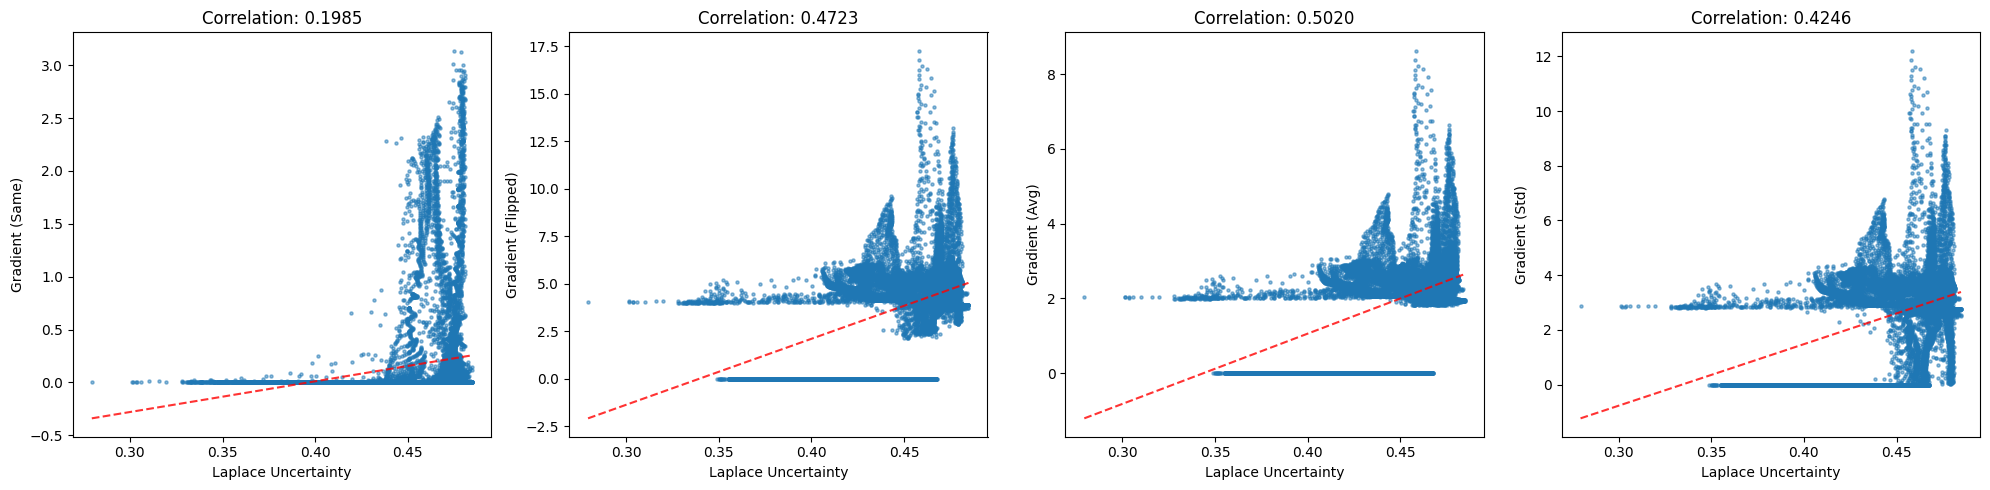

Experiment ID: complex_moons_standard_20250608_223128
Experiment Type: standard
Accuracy: 0.5000
Average gradient uncertainty (same label): 0.1567
Average gradient uncertainty (flipped label): 3.8442
Average of gradient uncertainties: 2.0004
Average std between gradient uncertainties: 2.6075
Average Laplace uncertainty: 0.4503
corr_laplace_gradient_uncertainty: 0.1985
corr_laplace_gradient_uncertainty_flipped: 0.4723
corr_laplace_grad_avg: 0.5020
corr_laplace_grad_std: 0.4246
Total plots saved: 10
Summary saved: experiment_summary.txt

EXPERIMENT SUMMARY

complex_moons_standard_20250608_223128:
  Type: standard
  Accuracy: 0.5000
  corr_laplace_grad_avg: 0.5020
  corr_laplace_grad_std: 0.4246
  corr_laplace_gradient_uncertainty: 0.1985
  corr_laplace_gradient_uncertainty_flipped: 0.4723

Total plots saved across all experiments: 10


In [83]:
results, saved_files = visualize_saved_experiments([exp2_id], save_plots=True, show_plots=True)

In [84]:
# Experiment 3: Simple model on blobs (MCMC)
exp3_data = train_mcmc_model(
    X_blobs, y_blobs, SimpleModel, prior_precision=0.01,
    num_samples=500, warmup_steps=100
)
exp3_id, _ = saver.save_experiment(exp3_data, "simple_blobs_mcmc")

Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.8303
Epoch [40/100], Loss: 0.5003
Epoch [60/100], Loss: 0.3266
Epoch [80/100], Loss: 0.2356
Epoch [100/100], Loss: 0.1830
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [28:37,  2.86s/it, step size=4.26e-06, acc. prob=0.756]

Accuracy on entire dataset: 0.5000
Experiment saved as: simple_blobs_mcmc_20250608_230032
Directory: saved_experiments/binary/simple_blobs_mcmc_20250608_230032


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74606/1655715741.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))



Visualizing experiment: simple_blobs_mcmc_20250608_230032
Saving plots to: saved_experiments/binary/simple_blobs_mcmc_20250608_230032
Saved: decision_boundary.png
Saved: mcmc_uncertainty.png
Saved: gradient_uncertainty.png
Saved: gradient_uncertainty_flipped.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


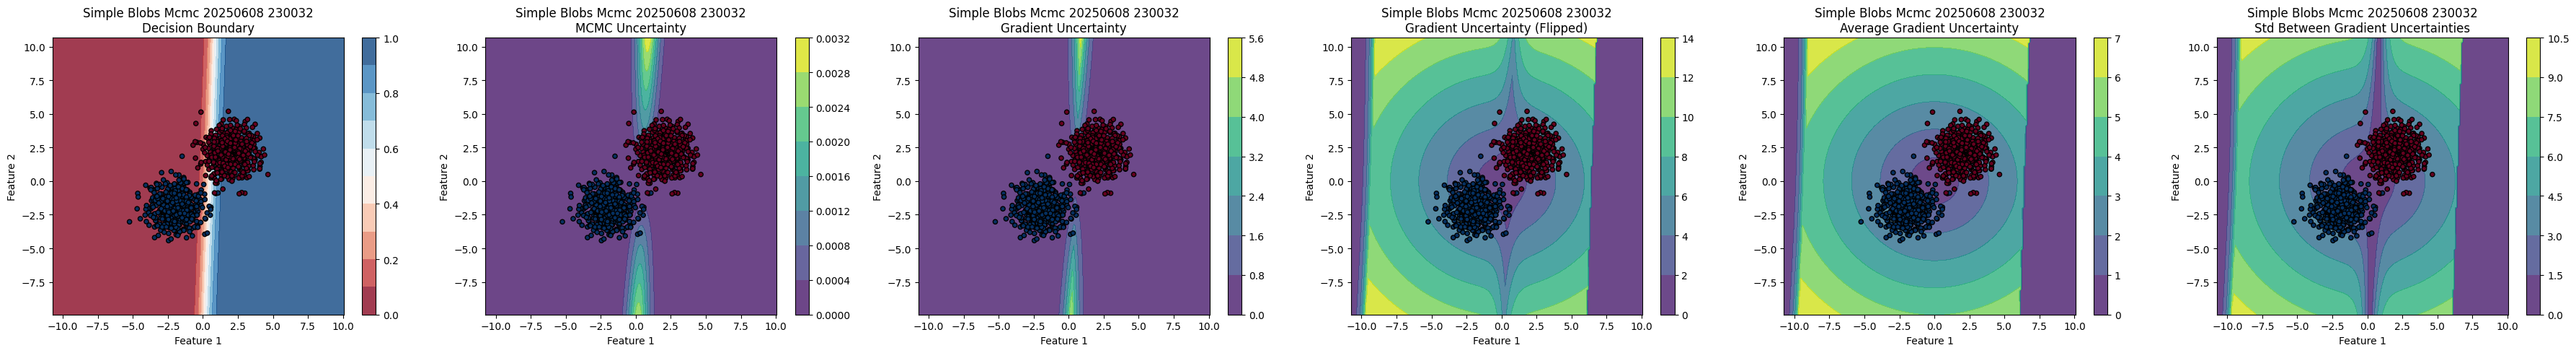

Saved: correlation_mcmc_gradient_uncertainty.png
Saved: correlation_mcmc_gradient_uncertainty_flipped.png
Saved: correlation_mcmc_grad_avg.png
Saved: correlation_mcmc_grad_std.png
Correlation between MCMC Uncertainty and Gradient (Same): 0.9812
Correlation between MCMC Uncertainty and Gradient (Flipped): -0.0148
Correlation between MCMC Uncertainty and Gradient (Avg): 0.1092
Correlation between MCMC Uncertainty and Gradient (Std): -0.1374


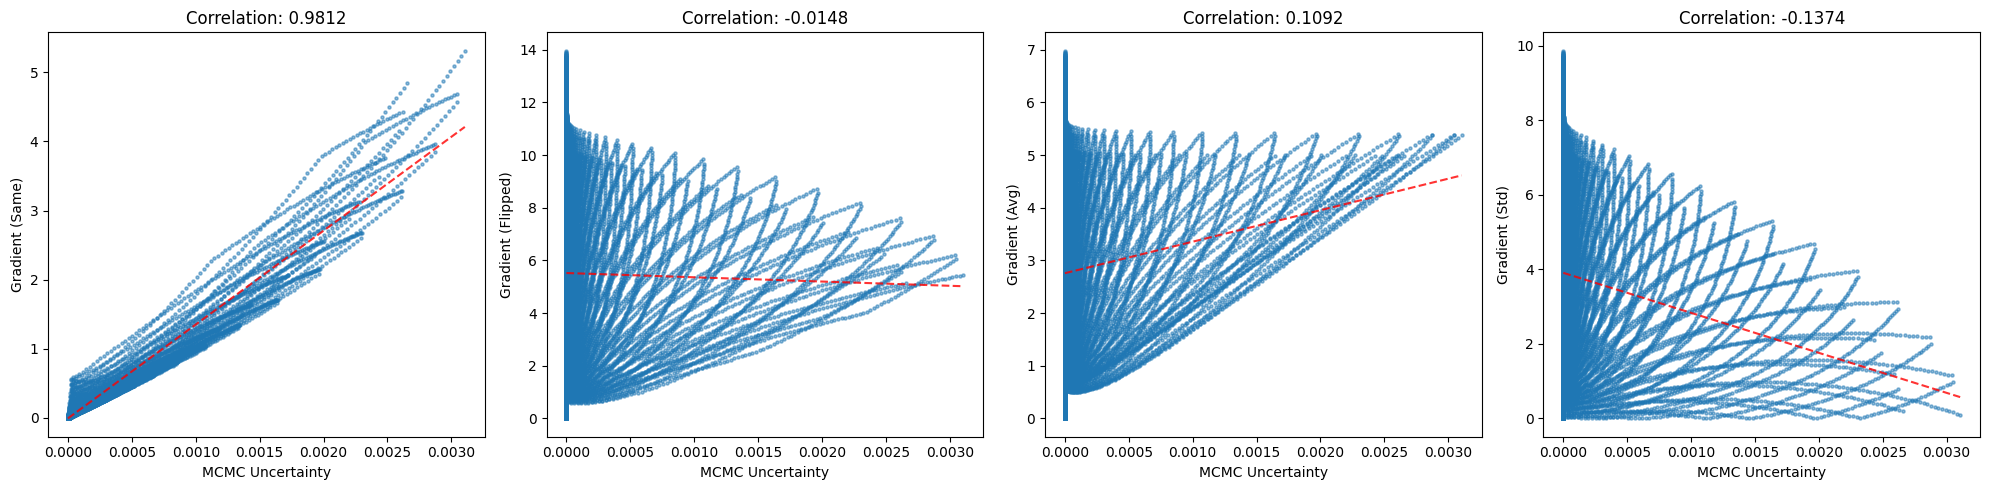

Experiment ID: simple_blobs_mcmc_20250608_230032
Experiment Type: mcmc
Accuracy: 0.5000
Average gradient uncertainty (same label): 0.1282
Average gradient uncertainty (flipped label): 5.5031
Average of gradient uncertainties: 2.8157
Average std between gradient uncertainties: 3.8006
Average MCMC uncertainty: 0.0001
corr_mcmc_gradient_uncertainty: 0.9812
corr_mcmc_gradient_uncertainty_flipped: -0.0148
corr_mcmc_grad_avg: 0.1092
corr_mcmc_grad_std: -0.1374
Total plots saved: 10
Summary saved: experiment_summary.txt

EXPERIMENT SUMMARY

simple_blobs_mcmc_20250608_230032:
  Type: mcmc
  Accuracy: 0.5000
  corr_mcmc_grad_avg: 0.1092
  corr_mcmc_grad_std: -0.1374
  corr_mcmc_gradient_uncertainty: 0.9812
  corr_mcmc_gradient_uncertainty_flipped: -0.0148

Total plots saved across all experiments: 10


In [85]:
results, saved_files = visualize_saved_experiments([exp3_id], save_plots=True, show_plots=True)

In [70]:
# Experiment 4: Complex model on moons (MCMC)
exp4_data = train_mcmc_model(
    X_moons, y_moons, ComplexModel, {"hidden_size": 32},
    prior_precision=0.001, num_samples=500, warmup_steps=100
)
exp4_id, _ = saver.save_experiment(exp4_data, "complex_moons_mcmc")

Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.5282
Epoch [40/100], Loss: 0.3631
Epoch [60/100], Loss: 0.3009
Epoch [80/100], Loss: 0.2720
Epoch [100/100], Loss: 0.2601
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [49:04,  4.91s/it, step size=3.87e-06, acc. prob=0.586]

Accuracy on entire dataset: 0.5000
Experiment saved as: complex_moons_mcmc_20250608_222843
Directory: saved_experiments/binary/complex_moons_mcmc_20250608_222843



Visualizing experiment: complex_moons_mcmc_20250608_222843


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74606/1655715741.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Saving plots to: saved_experiments/binary/complex_moons_mcmc_20250608_222843
Saved: decision_boundary.png
Saved: mcmc_uncertainty.png
Saved: gradient_uncertainty.png
Saved: gradient_uncertainty_flipped.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


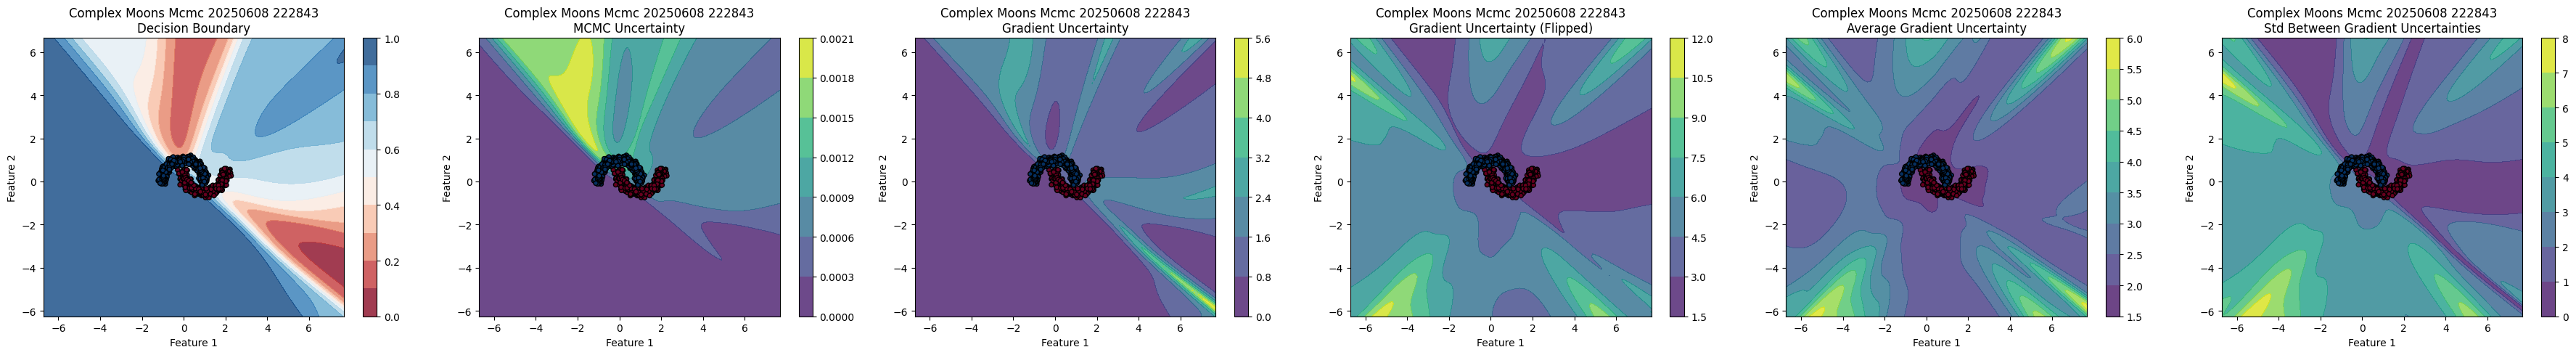

Saved: correlation_mcmc_gradient_uncertainty.png
Saved: correlation_mcmc_gradient_uncertainty_flipped.png
Saved: correlation_mcmc_grad_avg.png
Saved: correlation_mcmc_grad_std.png
Correlation between MCMC Uncertainty and Gradient (Same): 0.7859
Correlation between MCMC Uncertainty and Gradient (Flipped): -0.5087
Correlation between MCMC Uncertainty and Gradient (Avg): -0.1287
Correlation between MCMC Uncertainty and Gradient (Std): -0.6862


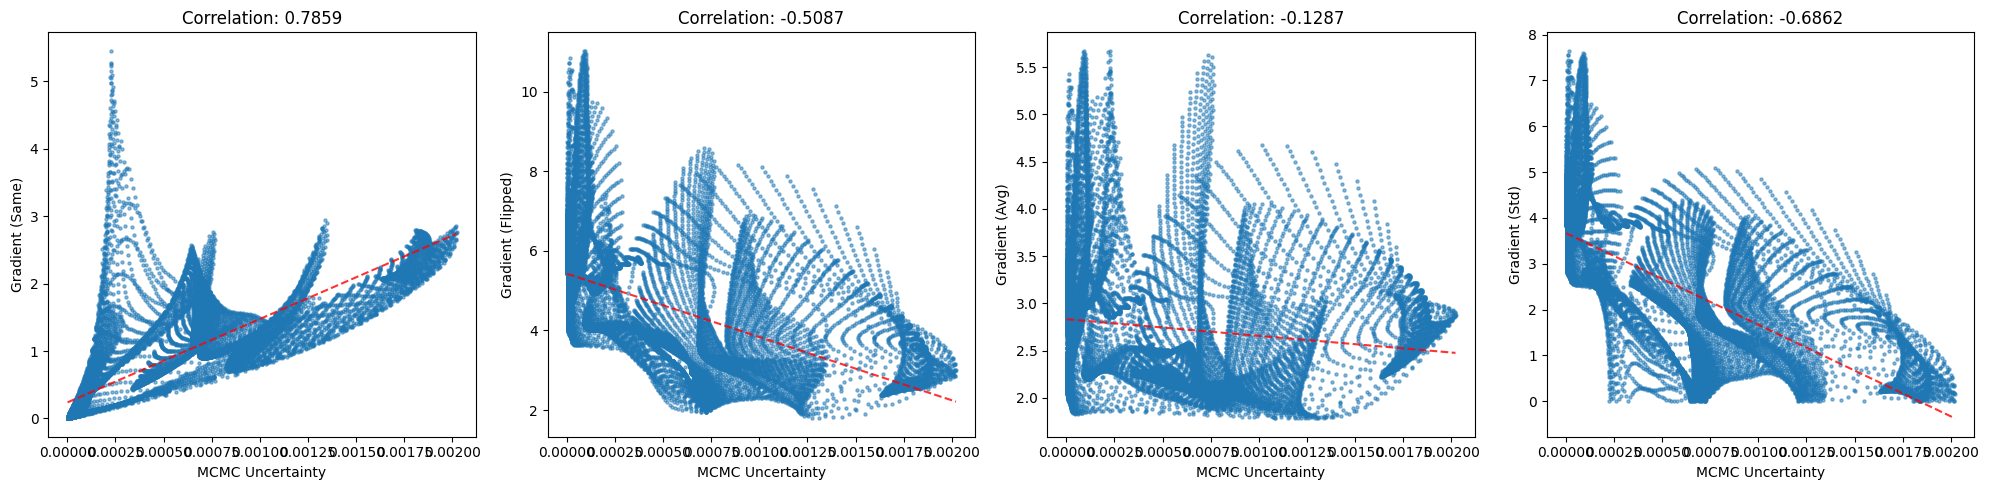

Experiment ID: complex_moons_mcmc_20250608_222843
Experiment Type: mcmc
Accuracy: 0.5000
Average gradient uncertainty (same label): 0.8218
Average gradient uncertainty (flipped label): 4.6754
Average of gradient uncertainties: 2.7486
Average std between gradient uncertainties: 2.7249
Average MCMC uncertainty: 0.0005
corr_mcmc_gradient_uncertainty: 0.7859
corr_mcmc_gradient_uncertainty_flipped: -0.5087
corr_mcmc_grad_avg: -0.1287
corr_mcmc_grad_std: -0.6862
Total plots saved: 10
Summary saved: experiment_summary.txt

EXPERIMENT SUMMARY

complex_moons_mcmc_20250608_222843:
  Type: mcmc
  Accuracy: 0.5000
  corr_mcmc_grad_avg: -0.1287
  corr_mcmc_grad_std: -0.6862
  corr_mcmc_gradient_uncertainty: 0.7859
  corr_mcmc_gradient_uncertainty_flipped: -0.5087

Total plots saved across all experiments: 10


In [71]:
results, saved_files = visualize_saved_experiments([exp4_id], save_plots=True, show_plots=True)